In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
#import os
#os.chdir('/content/drive/MyDrive/Real_data')

## Import Libraries

In [1]:
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pickle5
import math
import matplotlib.pyplot as plt

## Load pickle file

In [2]:
dir_name = './processed/'

def load_pickle(filename):
    with open(dir_name + filename + '.pkl', 'rb') as f:
        return pickle5.load(f)

## Initialisation - based on paper

In [3]:
img_size = 227
num_channels = 3
batch_size = 50
width, height = 256, 256
cropped_width, cropped_height = 227, 227
num_classes = 1

seed = 10
np.random.seed(seed)
tf.random.set_seed(seed)

# Learning rate
lr = 1e-3

From the paper, it said to drop the learning rate to 1e^-4 when epochs reach 10k.
(1e^-3 - 1e^-4) is a drop of 10%, hence we use 0.1

In [4]:
def step_decay(epoch):
    init_lrate = 1e-3
    drop = 0.1
    epochs_drop = 10000
    lrate = init_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

weight_init = keras.initializers.TruncatedNormal(mean=0.0,stddev=0.01,seed=seed)
#bias_init = tf.keras.initializers.Constant(value=0.1)
sgd = keras.optimizers.SGD(learning_rate=lr,momentum=0.0)
loss_func = keras.losses.BinaryCrossentropy()
lrate = keras.callbacks.LearningRateScheduler(step_decay)

## Depth

- 1fc: remove 2 Fully Connected layers
- 2fc: remove 1 FC
- 4conv: add 1 conv & maxpool before flattening
- 1fc4conv: 1fc + 4conv (i.e. remove 2 FCs, add 1 conv & maxpool before flattening)
- 2fc4conv: 2fc + 4conv

In [5]:
depth_type = '1fc4conv'

## Load and process data

In [6]:
to_pickle = [['train', 'test']]
for i in range(5):
  to_pickle.append(["fold_%s_train_sub"%i, "fold_%s_val"%i])

In [7]:
one_csv = to_pickle[0] # change
train_pickle = load_pickle(one_csv[0])
val_pickle = load_pickle(one_csv[1])

X_train = np.array(train_pickle['images'])    
y_train = np.array(train_pickle['genders'])

X_val = np.array(val_pickle['images'])
y_val = np.array(val_pickle['genders'])

Check that the image size is as described in the paper (256x256)

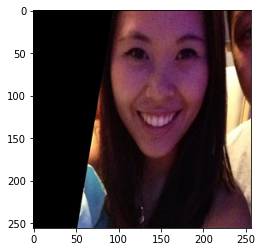

In [8]:
img = X_train[50,:,:,:]
plt.imshow(img)

Crop image and check that image is now cropped as described in paper (227x227)

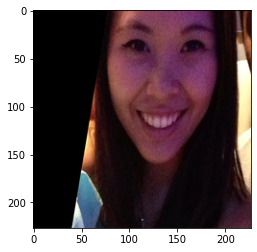

In [9]:
left = int((width - cropped_width)/2)
right = int((width + cropped_width)/2)
top = int((height - cropped_height)/2)
bottom = int((height + cropped_height)/2)

X_train = X_train[:,left:right,top:bottom,:]
X_val = X_val[:,left:right,top:bottom,:]

img = X_train[50,:,:,:]
plt.imshow(img)

## Model - based on paper

In [10]:
model = keras.models.Sequential()
# First convolution layer - 96 filters, 7x7 kernel, 4 strides, valid padding, relu
model.add(keras.layers.Conv2D(96, (7,7),input_shape = (cropped_width, cropped_height, num_channels), strides = 4,
                                  padding ='valid',activation = 'relu',kernel_initializer = weight_init))
# Max pooling - 3x3 kernel, 2 strides, channel last by default
model.add(keras.layers.MaxPool2D(pool_size = (3,3), strides = 2, padding = 'same'))
# Output - 96x28x28
model.add(keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(input=x, alpha=0.0001, beta=0.75)))

# Second convolution layer - 256 filters, 5x5 kernel, relu, same padding
model.add(keras.layers.Conv2D(256, (5,5), padding = 'same',activation = 'relu', kernel_initializer = weight_init))
# Max pooling - 3x3 kernel, 2 strides, channel last by default
model.add(keras.layers.MaxPool2D(pool_size = (3, 3), strides = 2,padding = 'same'))
#Output - 14x14
model.add(keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(input=x, alpha=0.0001, beta=0.75)))\

# Last convolution layer - 384 filters, 3x3 kernel, relu, same padding
model.add(keras.layers.Conv2D(384, (3,3),padding = 'same',activation = 'relu',kernel_initializer = weight_init))
# Max pooling - 3x3 kernel, 2 strides, channel last by default
model.add(keras.layers.MaxPool2D(pool_size = (3,3), strides = 2, padding = 'same'))

# 4conv: add 1 conv & maxpool before flattening
# conv layer - 512 filters, 3x3 kernel, relu
if depth_type in ['4conv', '1fc4conv', '2fc4conv']:
    model.add(keras.layers.Conv2D(512, (3,3),padding = 'valid', activation = 'relu', kernel_initializer = weight_init))
    model.add(keras.layers.MaxPool2D(pool_size = (2,2),strides = 1,padding = 'valid'))
    # Flatten
    model.add(keras.layers.Flatten())

# fc: remove 1/2 FCs
if (depth_type not in ['1fc', '1fc4conv', '2fc', '2fc4conv']):
    # FC1:
    model.add(keras.layers.Dense(512, activation = "relu", kernel_initializer = weight_init))
    # Dropout
    model.add(keras.layers.Dropout(0.5))

# 1fc: remove 2 FCs
if (depth_type not in ['1fc', '1fc4conv']):
    # FC2:
    model.add(keras.layers.Dense(512, activation = "relu", kernel_initializer = weight_init))
    # Dropout
    model.add(keras.layers.Dropout(0.5))
        
#FC3 - Third, fully connected layer which maps to the final classes for age or gender
model.add(keras.layers.Dense(num_classes, activation = 'sigmoid', kernel_initializer = weight_init))

model.compile(loss=loss_func,optimizer=sgd,metrics=['accuracy'])

dir_name = './depth_model/'
if not os.path.isdir(dir_name):
  os.mkdir(dir_name)

checkpoint = keras.callbacks.ModelCheckpoint(dir_name + one_csv[0][:6] + '.ckpt', monitor='val_accuracy', 
                                                 verbose=1, mode='max', save_best_only = True)
csv_logger = keras.callbacks.CSVLogger(dir_name + one_csv[0][:6] + '.csv')
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',patience=4)
callbacks = [lrate,checkpoint,csv_logger,early_stopping]

num_epochs = 50
#if one_csv[0][:4] == 'fold':
  #num_epochs = 500

model.summary()
results = model.fit(X_train, y_train,
                        batch_size = batch_size,
                        epochs = num_epochs,
                        verbose=2,
                        callbacks=callbacks,
                        validation_data = (X_val,y_val))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 56, 96)        14208     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 28, 96)       0         
 )                                                               
                                                                 
 lambda (Lambda)             (None, 28, 28, 96)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 256)      0         
 2D)                                                             
                                                                 
 lambda_1 (Lambda)           (None, 14, 14, 256)       0

280/280 - 214s - loss: 0.1763 - accuracy: 0.9362 - val_loss: 0.2674 - val_accuracy: 0.8900 - lr: 0.0010 - 214s/epoch - 764ms/step
Epoch 25/50

Epoch 00025: val_accuracy improved from 0.89003 to 0.89261, saving model to ./depth_model\train.ckpt
INFO:tensorflow:Assets written to: ./depth_model\train.ckpt\assets
280/280 - 214s - loss: 0.1613 - accuracy: 0.9420 - val_loss: 0.2604 - val_accuracy: 0.8926 - lr: 0.0010 - 214s/epoch - 764ms/step
Epoch 26/50

Epoch 00026: val_accuracy did not improve from 0.89261
280/280 - 212s - loss: 0.1508 - accuracy: 0.9461 - val_loss: 0.3445 - val_accuracy: 0.8551 - lr: 0.0010 - 212s/epoch - 756ms/step
Epoch 27/50

Epoch 00027: val_accuracy did not improve from 0.89261
280/280 - 206s - loss: 0.1387 - accuracy: 0.9538 - val_loss: 0.2674 - val_accuracy: 0.8920 - lr: 0.0010 - 206s/epoch - 736ms/step
Epoch 28/50

Epoch 00028: val_accuracy did not improve from 0.89261
280/280 - 205s - loss: 0.1269 - accuracy: 0.9591 - val_loss: 0.2921 - val_accuracy: 0.8780 - lr

Train-Test Accuracy vs Epochs

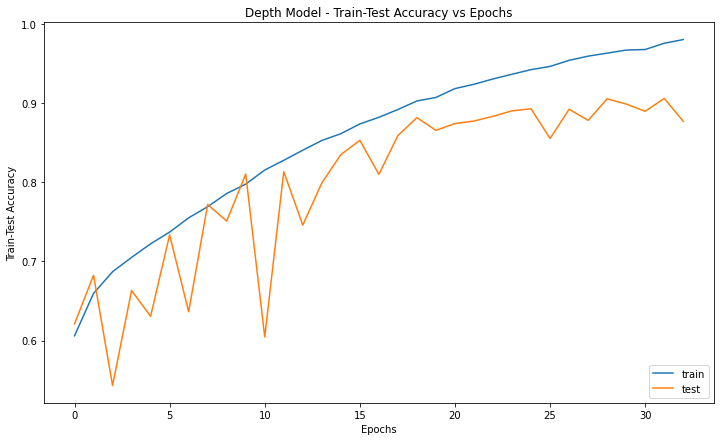

In [11]:
plt.figure(figsize=(12,7))
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Depth Model - Train-Test Accuracy vs Epochs')
plt.ylabel('Train-Test Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','test'],loc='lower right')
plt.savefig(dir_name + '/train_test_acc.png')
plt.show()

Train-Val Loss vs Epochs

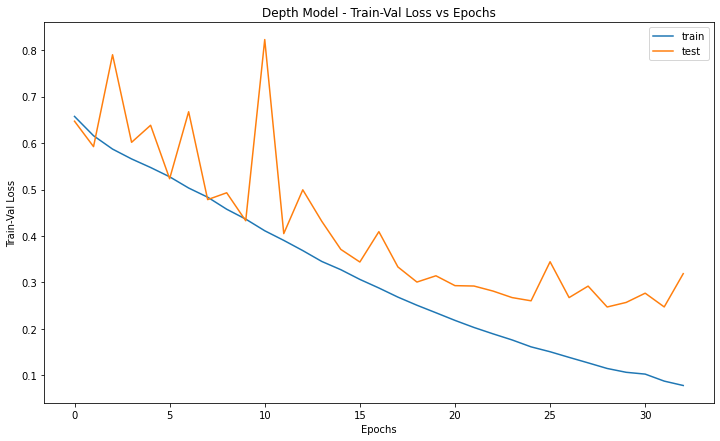

In [12]:
plt.figure(figsize=(12,7))
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Depth Model - Train-Val Loss vs Epochs')
plt.ylabel('Train-Val Loss')
plt.xlabel('Epochs')
plt.legend(['train','test'],loc='upper right')
plt.savefig(dir_name + '/train_test_loss.png')
plt.show()